# Fitting occultation of WASP-127b

In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN3

##### ------------------------------------

The CONAN3 has 3 major classes that are used to store information about the input files and also perform computations.

They are:
- `load_lightcurves` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters. It contains methods to configure the LCs for fitting such as:

    - `lc_baseline`
    - `add_GP`
    - `setup_transit_rv`
    - `transit_depth_variation`
    - `setup_occulation`
    - `limb_darkening`
    - `contamination_factors`
    - `stellar_parameters`
    
    
- `load_rvs` : same as above but for rvs
- `mcmc_setup` : object to hol mcmc configuration

These objects are then given as input to the `fit_data` function to perform sampling. 

Example

### light curve object

In [2]:
path = "../w127_lcs/"
lcs = sorted(glob(f"{path}w127*"))
lc_list = [basename(lc) for lc in lcs[:1]]

print(lc_list)

['w127_pipe1.txt']


In [3]:
lc_data = CONAN3.load_lightcurves(lc_list, path, filters = "CH", lamdas=6000)
lc_data

Filters: ['CH']
Order of unique filters: ['CH']


Object containing 1 lightcurves
Files:['w127_pipe1.txt']
Filepath: ../w127_lcs/

- The lc_data object holds information now about the light curves. The light curves can be plotted using the `plot` method of the object.

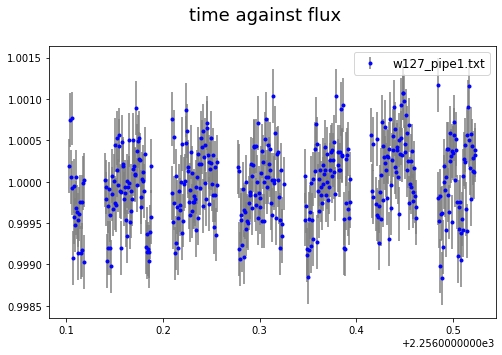

In [4]:
lc_data.plot()

- correlations between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 (roll angle) against column 1 (flux)

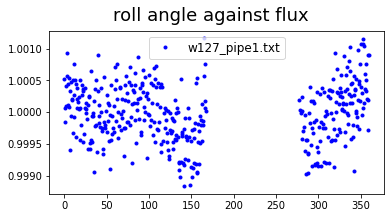

In [5]:
lc_data.plot(plot_cols=(5,1), col_labels=("roll angle","flux"), figsize=(6,3))

- the baseline model for each lightcurve in the lc_data object can be defined using the `lc_baseline` 

the polynomial order for the cotrending vectors (t, x, y, phi, conta, bg/sky...) is specified for each lightcurve (lc) in lc_data. A list of equal to number of lcs is expected. if a single integer is given, the same is used for all lcs. "y" or "n" can be used to specify if an lc baseline should include a gp.

Error reporting will help catch most mistakes :)

*(t, x, y, phi, conta, bg/sky...)  correspond to columns of the input data --> columns 0, 3 4,5,6,7 respectively. Any desired array can be put in these columns to decorrelate against them irrespective of the name here (which would be modified soon)



In [6]:
lc_data.lc_baseline(dt = 2, dx=2, dy=0, dsky=1, gp="y")

#--------------------------------------------- 
# Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
w127_pipe1.txt 	CH 	6000.0	    2	   0	 2	 0	     0	   1	   0	     0	  1	 y 


In [7]:
gp_lcs = list(lc_data._gp_lcs)
gp_lcs

['w127_pipe1.txt']

- add GPs to specified lcs. only lcs with GP = 'y' above can be included.

the independent variable of the gp can be any of ["time", "xshift", "yshift", "air", "fwhm", "sky"] again corresponding to columns of the input data --> columns 0, 3 4,5,6,7. to be changed soon 

the `pars` argument specifies the independent gp variable for each lc by taking a list of strings from the options above. if  single string is given, same independent variable is used for all specified lcs. To apply a two dimensional GP on an lc, the file name must be given twice and the corresponding `pars` value will specify the variable of the different dimensions.

similarly `kernels` argument specifies the kernel for each specified lc

The `log_scale` and `log_metric` arguments specify the prior of the variance and lengthscale of the GP kernel applied for each specified lc. It is given as follows:
* if tuple is of len 2, set normal prior with index[0] as prior mean and index[1] as prior width.
* if tuple is of len 3, set uniform prior with between index[0] and index[2], index[1] is the initial value.

if a single tuple is given, same prior is used for all specified lcs


To apply a GP to the first lc:

In [8]:
gp_list = gp_lcs#*2
gp_list

['w127_pipe1.txt']

In [9]:
lc_data.add_GP(lc_list = gp_list,
               pars = ["air"],
               kernels = ["mat32"],
               log_scale = (-25,-17.83,-10),
               log_metric = [(0,7.7,20)],
               m_step=0.01,
               verbose = True)

# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
w127_pipe1.txt air   mat32  y  1.8e-08 0.1000   0.0  0.00e+00 -10.0 -25.0 2.2e+03 0.0100  0.00  0.00e+00 20.0  0.0


### Transit parameters

The model paramters are: ['RpRs', 'Impact_para', 'Duration', 'T_0', 'Period', 'Eccentricity', 'Omega', 'K']

The parameters can be defined in following ways:

* fixed value as float or int, e.g Period = 3.4
* free parameter with gaussian prior given as tuple of len 2, e.g. T_0 = (5678, 0.1)
* free parameters with uniform prior interval and initial value given as tuple of length 3, e.g. RpRs = (0,0.1,0.2) with 0.1 being the initial value.

In [10]:
lc_data.setup_transit_rv(RpRs = 0.10104, Period=4.17806203,
                        Impact_para = 0.29, Duration=0.18137,
                        T_0 = (808.60255046,0.00031))

#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	n  	 0.10104	0.0000000	0.00	1.00	n	0.10104	0.0e+00	0.0e+00 
Impact_para 	n  	 0.29000	0.0000000	0.00	1.00	n	0.29000	0.0e+00	0.0e+00 
Duration    	n  	 0.18137	0.0000000	0.00	1.00	n	0.18137	0.0e+00	0.0e+00 
T_0         	y  	808.60255	0.0000031	0.00	10000.00	p	808.60255	3.1e-04	3.1e-04 
Period      	n  	 4.17806	0.0000000	0.00	10000.00	n	4.17806	0.0e+00	0.0e+00 
Eccentricity	n  	 0.00000	0.0000000	0.00	1.00	n	0.00000	0.0e+00	0.0e+00 
omega       	n  	90.00000	0.0000000	0.00	360.00	n	90.00000	0.0e+00	0.0e+00 
K           	n  	 0.00000	0.0000000	0.00	10000.00	n	0.00000	0.0e+00	0.0e+00 


In [11]:
#time, flux, err, xshift, yshift, roll, thermfront2, bg, exp

#### optional configurations

These  functions are already loaded empty by default, so they only need to called unless one needs to define different inputs for them

In [16]:
lc_data.transit_depth_variation((0.10104,0))

#=========== ddF setup ============================================================================== 
Fit_ddFs  step	 low_lim   up_lim   prior   sig_lo   sig_hi   div_white
n         0.001	 -1.0000   1.0000   n       0.00000   0.00000   n  
group_ID   RpRs_0   err		dwfile
     1	   0.1010   0.00e+00   dw_001.dat


In [18]:
lc_data.setup_occultation("all", start_depth=(0,0.000,500e-6))

fitting occultation depth for filters: ['CH']

#=========== occultation setup ============================================================================= 
filters	fit start_val	stepsize  low_lim   up_lim    prior  value     sig_lo  	sig_hi  
CH     	y   0.000e+00	1.00e-05  0.00e+00  5.00e-04  n      0.00e+00  0.00e+00	0.00e+00 


In [19]:
lc_data.limb_darkening()

#=========== Limb darkending setup ===================================================================
filters priors	c_1  step1  low_lim1  up_lim1	c_2  step2 low_lim2 up_lim2
CH      n     	0.000 0.000  0.0000  0.0000	0.000 0.000  0.0000  0.0000


In [20]:
lc_data.contamination_factors()

#=========== contamination setup === give contamination as flux ratio ================================
filters	contam	err
CH     	0.0000	0.0000


In [21]:
lc_data.stellar_parameters(R_st=(2.36,0.03),
                           M_st=(2.03,0.066))

#=========== Stellar input properties ================================================================
# parameter    value  sig_lo  sig_hi 
Radius_[Rsun]  2.360  0.030  0.030 
Mass_[Msun]    2.030  0.066  0.066
Stellar_para_input_method:_R+rho_(Rrho),_M+rho_(Mrho),_M+R_(MR): MR


In [22]:
lc_data

Object containing 1 lightcurves
Files:['w127_pipe1.txt']
Filepath: ../w127_lcs/

- the full defined options for the light curve can be seen by using the print method on the `lc_data` object

In [24]:
lc_data.print()

#--------------------------------------------- 
# Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
w127_pipe1.txt 	CH 	6000.0	    2	   0	 2	 0	     0	   1	   0	     0	  1	 y 
# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
w127_pipe1.txt air   mat32  y  1.8e-08 0.1000   0.0  0.00e+00 -10.0 -25.0 2.2e+03 0.0100  0.00  0.00e+00 20.0  0.0
#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	n  	 0.10104	0.0000000	0.00	1.00	n	0.10104	0.0e+00	0.0e+00 
Impact_para 	n  	 0.29000	0.0000000	0.00	1.00	n	0.29000	0.0e+00	0.0e+00 
Duration    	n  	 0.18137	0.0000000	0.00	1.00	n	0.18137	0.0e+00	0.0e+00 
T_0         	y  	80

### RV data if available

Here we assume no rv data

In [25]:
rv_data= CONAN3.load_rvs()
rv_data

Object containing 0 rvs
Files:[]
Filepath: /Users/tunde/OneDrive - unige.ch/mygit/CONAN3/example

In [26]:
rv_data.plot()

No data to plot


In [27]:
rv_data.rv_baseline()

# ------------------------------------------------------------
# Input RV curves, baseline function, gamma  
name            time  bis  fwhm  contrast  gamma_kms  stepsize  prior  value  sig_lo  sig_hi


In [29]:
rv_data.print()

# ------------------------------------------------------------
# Input RV curves, baseline function, gamma  
name            time  bis  fwhm  contrast  gamma_kms  stepsize  prior  value  sig_lo  sig_hi


### setup mcmc object

In [30]:
mcmc = CONAN3.mcmc_setup(n_steps=1000, n_burn=2000, sampler="demc")

#=========== MCMC setup ==============================================================================
Total_no_steps           64000 
Number_chains            64 
Number_of_processes      2 
Burnin_length            2000 
Walk_(snooker/demc/mrw)  demc 
GR_test_(y/n)            y 
Make_plots_(y/n)         n 
leastsq_(y/n)            y 
Savefile                 output_ex1.npy 
Savemodel                n 
Adapt_base_stepsize      y 
Remove_param_for_CNM     n 
leastsq_for_basepar      n 
lssq_use_Lev-Marq        n 
apply_CFs                y 
apply_jitter             y


#### create a config file from defined parameters

In [34]:
CONAN3.create_configfile(lc_data, rv_data, mcmc,
                         filename='input_config_w127_example.dat')

#### finally fit using the 3 objects

finally perform the fitting which is saved to a `results` object that holds the chains of the mcmc and allows subsequent plotting

In [35]:
result = CONAN3.fit_data(lc_data, rv_data, mcmc)

CONAN3 launched
Setting up photometry arrays
Setting up photometry GPs
Setting up RV arrays
Plotting initial guess
Lightcurve number: 0
GPuse: [-19.80697511 -17.83         7.7       ]
Running MCMC
No of dimensions:  11
No of chains:  64
['T_0' 'CH_DFocc' 'w127_pipe1.txt_A0' 'w127_pipe1.txt_A1'
 'w127_pipe1.txt_A2' 'w127_pipe1.txt_C11' 'w127_pipe1.txt_C12'
 'w127_pipe1.txt_E1' 'GPphotWN_lc1' 'GPphotscale_lc1dim3'
 'GPphotmetric_lc1dim3']

Running first burn-in...


100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.13it/s]


Running second burn-in...


100%|███████████████████████████████████████| 2000/2000 [07:47<00:00,  4.28it/s]


Running production...


100%|███████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]


Mean acceptance fraction: 0.181
Plotting output figures
Lightcurve number: 0
GPuse: [-17.19123286 -16.8543378    8.53689415]
Lightcurve number: 0
GPuse: [-17.11112753 -17.71771086   7.84755873]
[0.9326408] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0002]
[0.9326408] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0002]
[0.9326408] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0002]
[0.9326408] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0002]
[1.00010607] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0001736]
[1.00010606] 0.0003687971237282224 0.00032586791767554485 [412.] [0.0001736]
[1.] 0.0003687971237282224 0.00032586791767554485 [412.] [0.00017365]
[0.99999999] 0.0003687971237282224 0.00032586791767554485 [412.] [0.00017365]
[1.] 0.0003687971237282224 0.00032586791767554485 [412.] [0.00017365]


### results

In [36]:
result

Object containing chains from mcmc.                 
Parameters in chain are:
	 dict_keys(['T_0', 'CH_DFocc', 'w127_pipe1.txt_A0', 'w127_pipe1.txt_A1', 'w127_pipe1.txt_A2', 'w127_pipe1.txt_C11', 'w127_pipe1.txt_C12', 'w127_pipe1.txt_E1', 'GPphotWN_lc1', 'GPphotscale_lc1dim3', 'GPphotmetric_lc1dim3'])                 

use `plot_chains`, `plot_corner` or `plot_posterior` methods on selected parameters to visualize results.

The parameters in the results object can be obtained using

In [38]:
result._par_names

dict_keys(['T_0', 'CH_DFocc', 'w127_pipe1.txt_A0', 'w127_pipe1.txt_A1', 'w127_pipe1.txt_A2', 'w127_pipe1.txt_C11', 'w127_pipe1.txt_C12', 'w127_pipe1.txt_E1', 'GPphotWN_lc1', 'GPphotscale_lc1dim3', 'GPphotmetric_lc1dim3'])

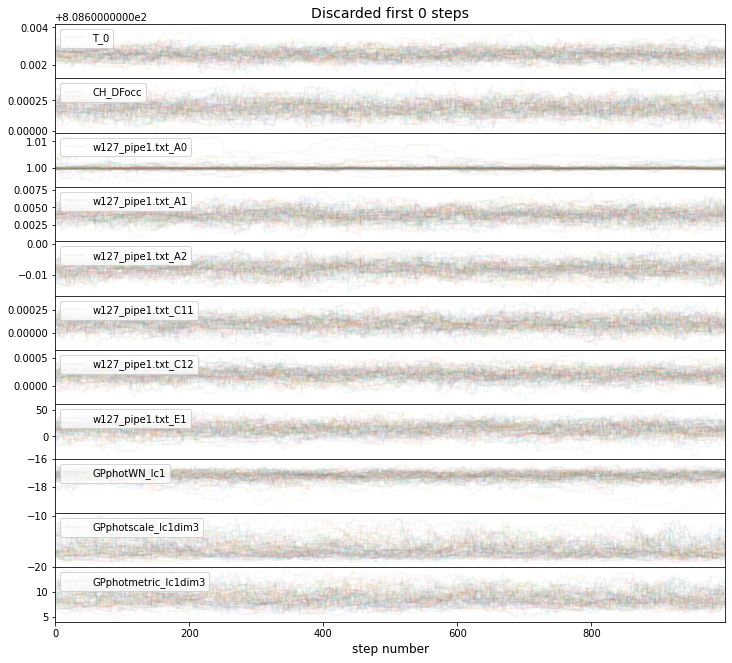

In [39]:
fig = result.plot_chains(pars="all")

if there are too many parameters (>20) in fit, a subset of this can be used to make the plots e.g by setting 

pars = ['T_0', 'CH_DFocc', 'GPphotWN_lc1', 'GPphotscale_lc1dim3', 'GPphotmetric_lc1dim3']

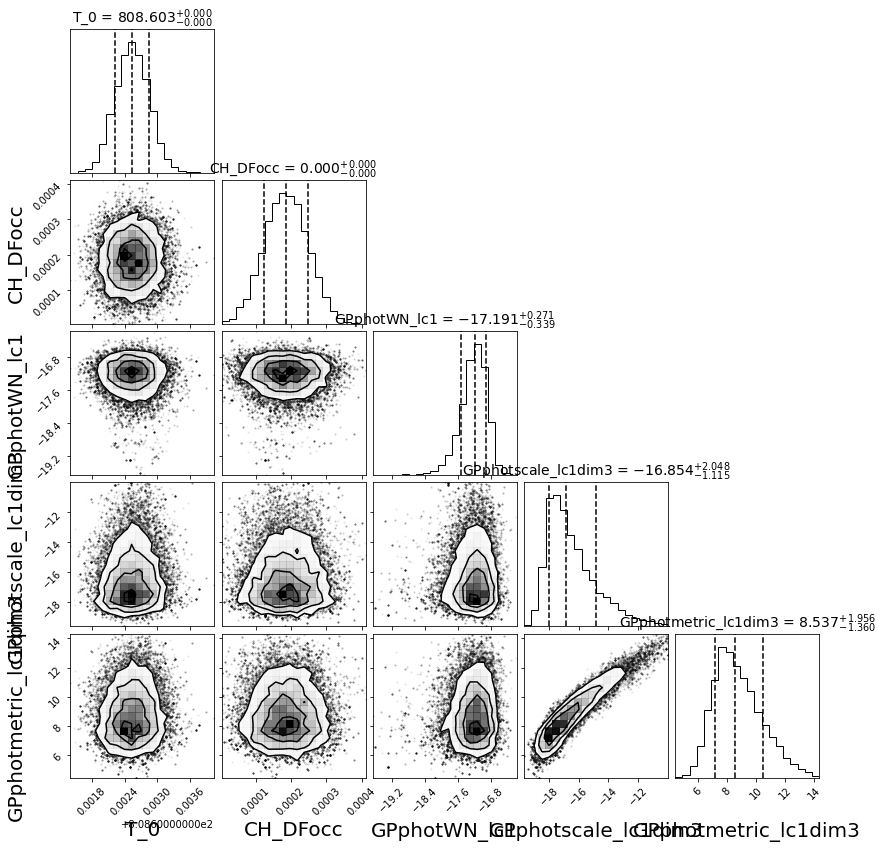

In [40]:
result.plot_corner(pars = ['T_0', 'CH_DFocc','GPphotWN_lc1', 'GPphotscale_lc1dim3', 'GPphotmetric_lc1dim3']);

- to show the occultation depth, CH_DFocc, values properly (in ppm) in the corner plot we can set a multiplicative factor for each parameter in the plot

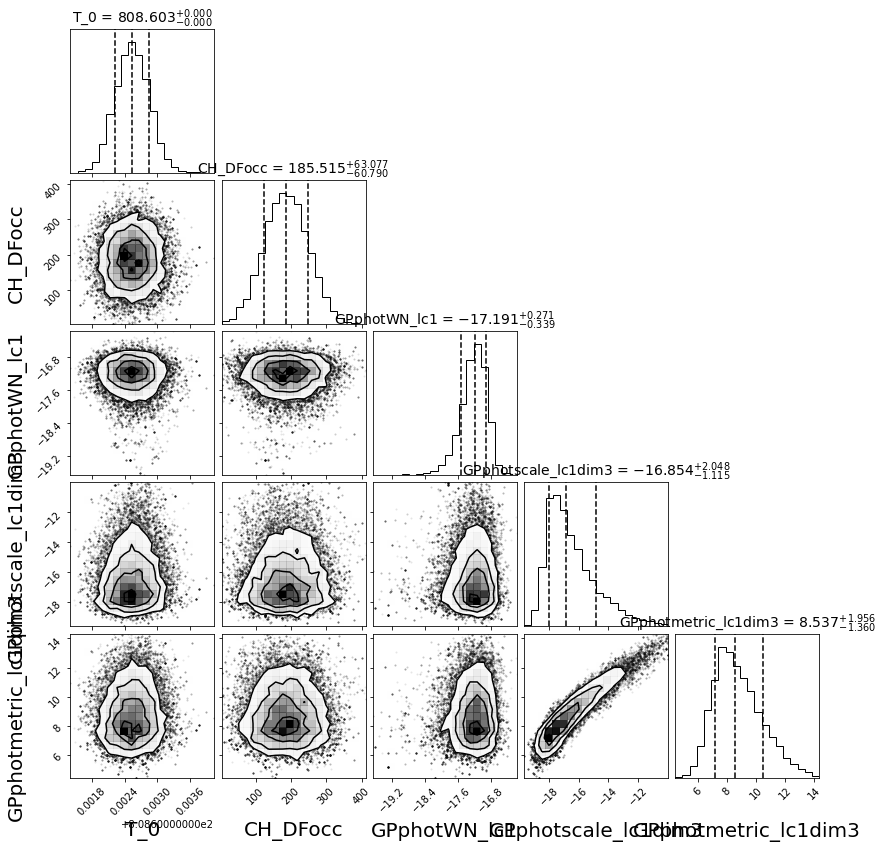

In [41]:
mult = [1,1e6,1,1,1]
result.plot_corner(pars = ['T_0', 'CH_DFocc','GPphotWN_lc1', 'GPphotscale_lc1dim3', 'GPphotmetric_lc1dim3'],
                  multiply_by=mult);

## Load saved results

The result object is, by default, saved as a pickle file (named "chains_dict.pkl" ).

This allows the chains to be loaded into memory to make visualize results 

In [42]:
import CONAN3
ch = CONAN3.load_chains()    #loads the chains_dict.pkl by default (the file can be renamed and passed as argument)

we can choose to discard the few points if we see that the first few chains were not "burned".

we can also thin if required

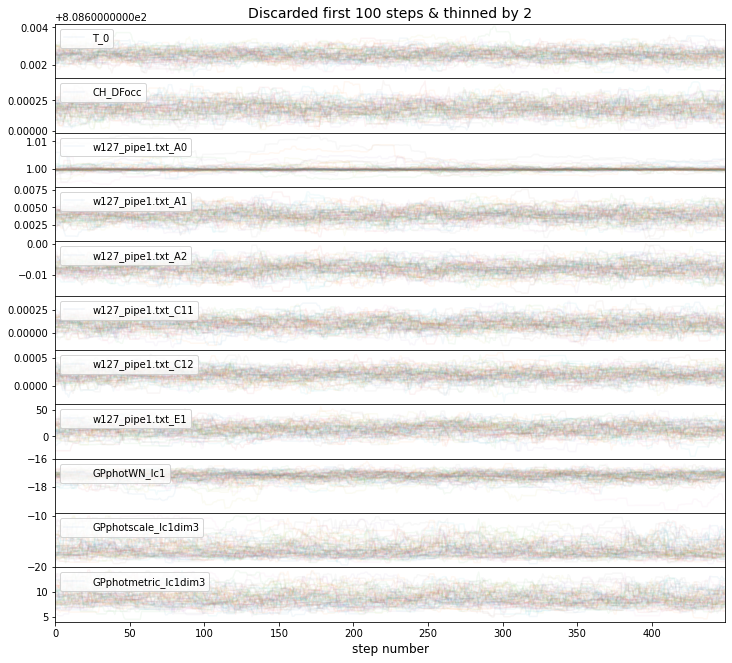

In [45]:
fig = ch.plot_chains(discard=100, thin=2)

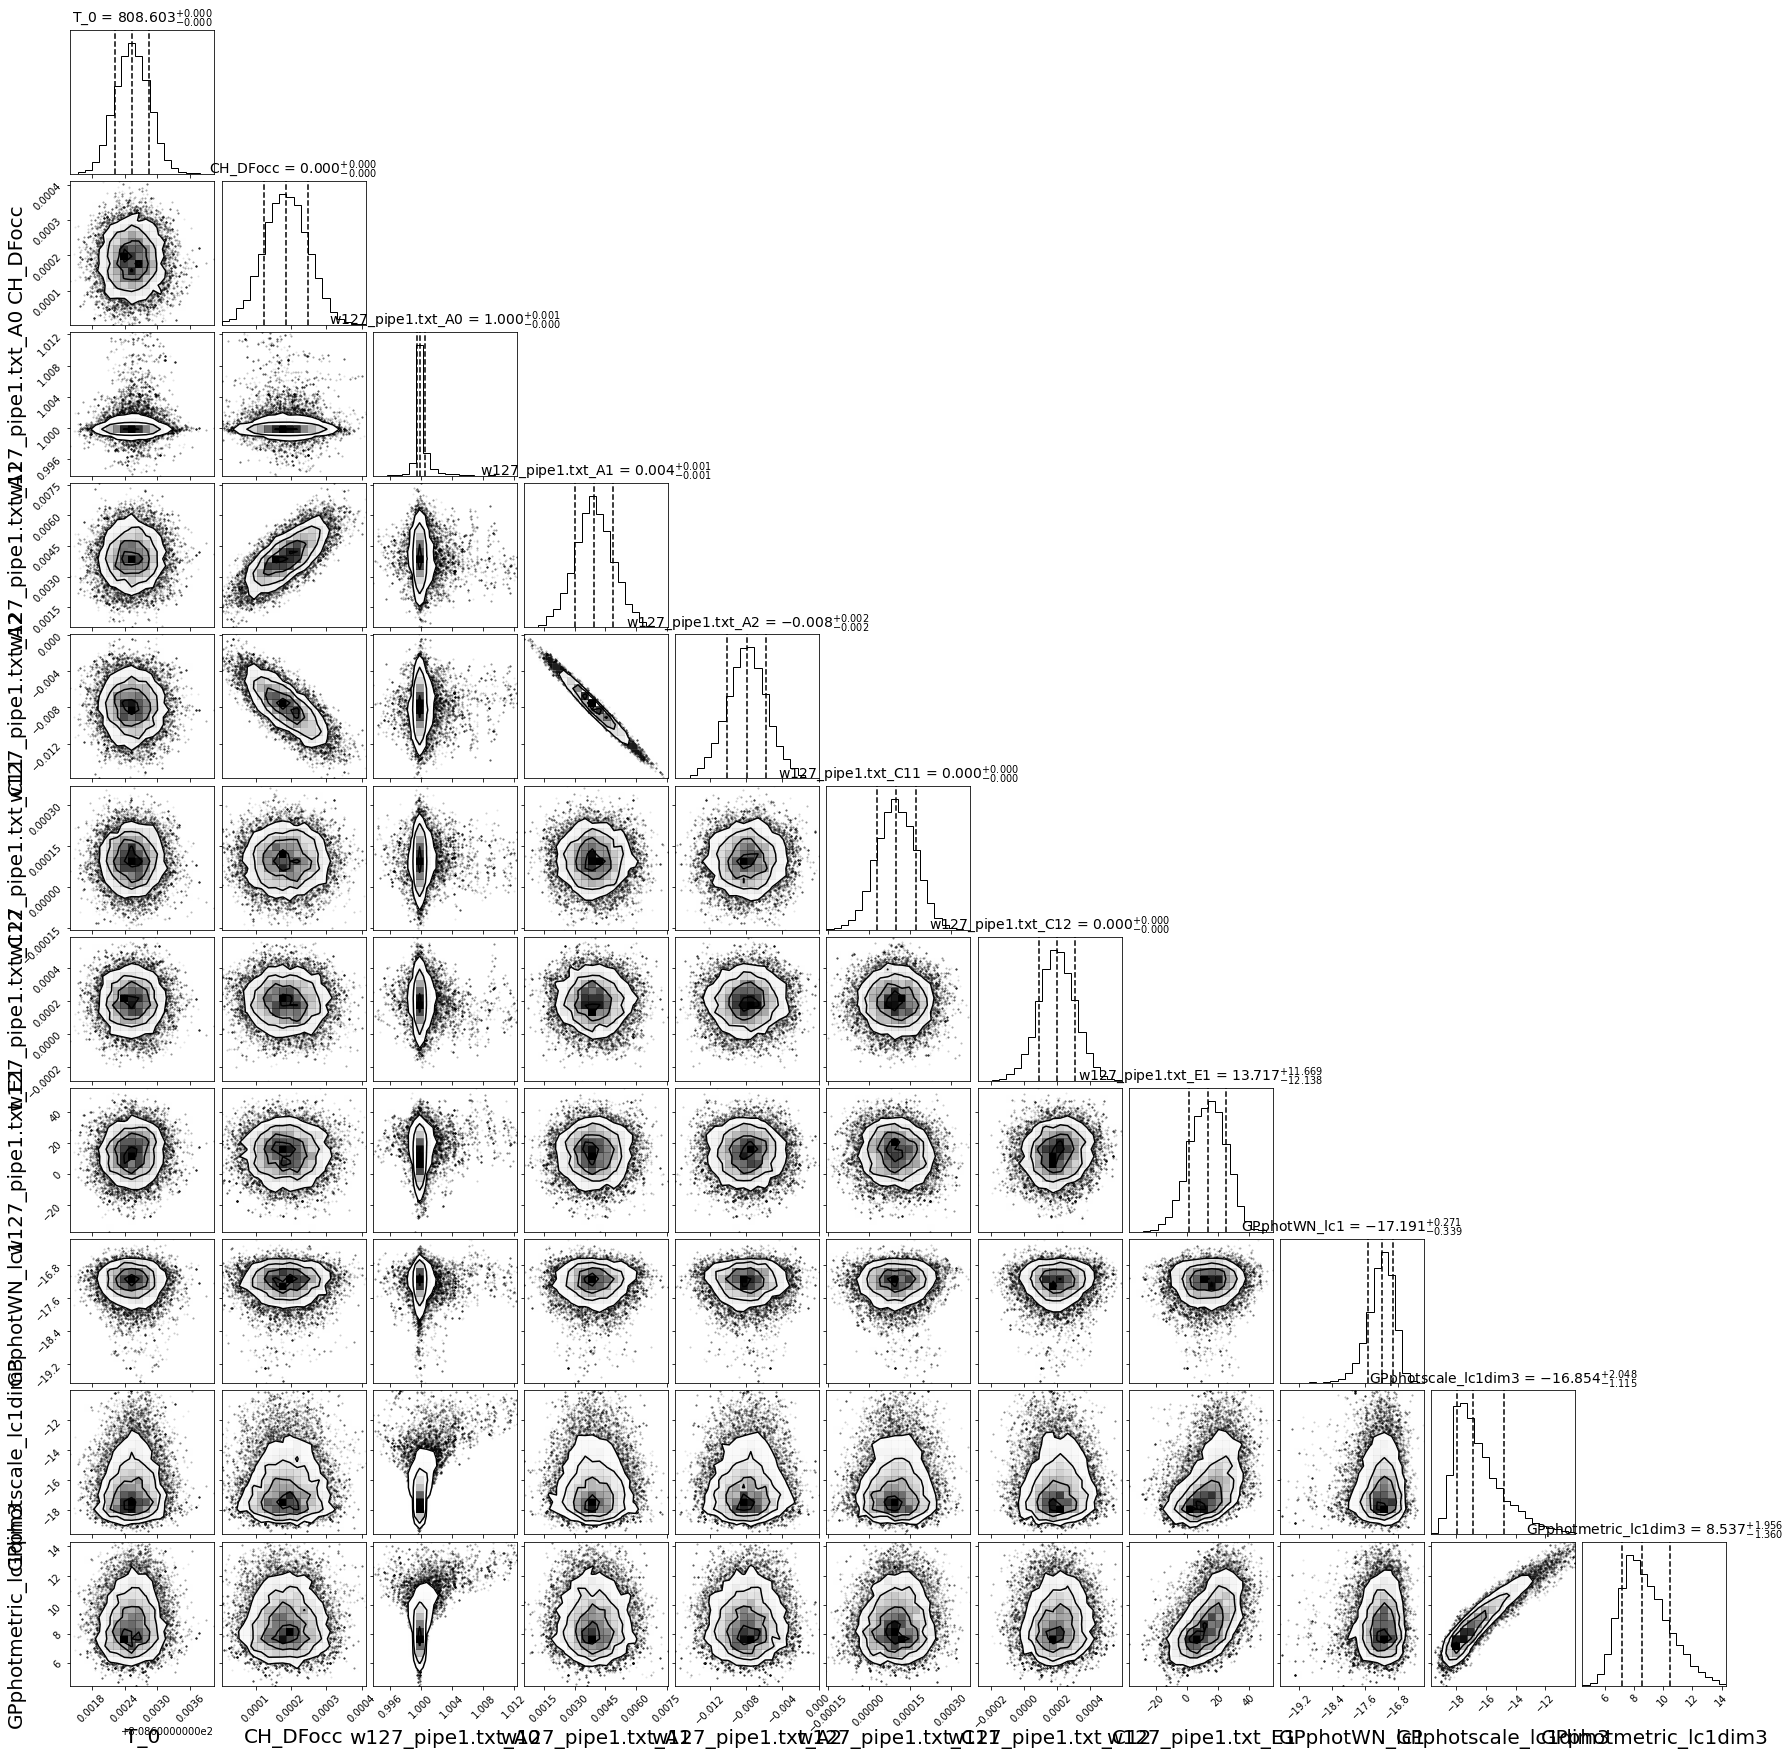

In [46]:
fig = ch.plot_corner(force_plot=True)

the `force_plot` option enforces a plot even if the parameters are too many to create a reasonanbly visible plot

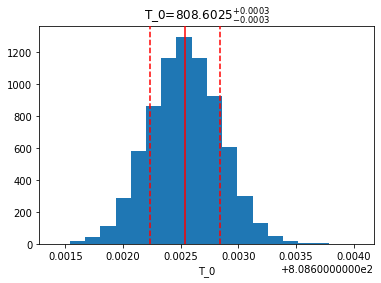

In [48]:
fig = ch.plot_posterior("T_0",q=[0.16,0.5,0.84])

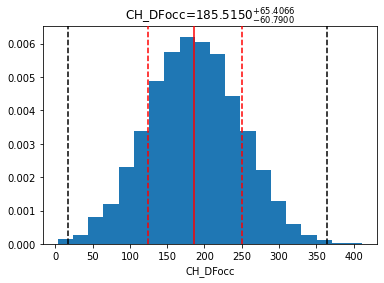

In [49]:
ch.plot_posterior('CH_DFocc', multiply_by=1e6);